## Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
import scikitplot as skplt

### Load data

In [2]:

d = './data/Iopamidol_ZSpectra/'

data = pd.DataFrame()

files = []
for root, dirs, files in os.walk(d):
    
    for i,file in enumerate(files):
        
        if file.endswith(".csv"):
            f = os.path.join(root, file)
            exp = pd.read_csv(f)
            #print(f, exp.pH.min())
      
            data = pd.concat( (data,  exp) )



### Data cleaning "by hand"

In [3]:
data = data.assign( pH_corr = data.pH.replace([4.16],[7.16]) )

## Experimental conditions

In [4]:
metadata = ['pH', 'Conc(mM)', 'ApproT1(sec)', 'Temp', 'SatPower(uT)', 'SatTime(ms)','pH_corr']

for C in metadata:
    print(C)
    print(data[C].unique())
    print('---'*20)

pH
[6.23 6.42 6.56 6.72 6.86 7.05 7.14 7.31 6.27 6.4  6.52 6.69 6.85 6.96
 7.12 7.28 6.28 6.38 6.54 6.68 7.02 7.13 7.29 6.73 6.83 6.98 7.18 6.26
 6.44 6.53 6.82 7.01 6.58 6.84 4.16 7.16 7.27 6.41 6.57 6.71 6.97 6.39
 6.43 6.67 6.7  6.99 7.03 7.32 6.22 7.17]
------------------------------------------------------------
Conc(mM)
[ 5.19  5.15  5.18  5.13  5.1   5.03  5.17  5.11  4.98  5.06  5.05  5.
  4.81  5.16  5.02  4.99 51.67 51.55 51.38 51.69 51.33 51.01 50.39 50.
 49.7  49.65 49.8  49.51 49.46 48.92 48.36 47.62 49.78 49.67 49.36 49.02
 49.77 49.86 49.6  49.85 49.63 49.31 49.88 48.83 48.68 48.77 48.53 48.35
 47.88 47.89 24.94 24.81 24.9  24.84  4.97  4.95  4.89 24.73 24.61 24.87
 24.97 24.95 24.91 24.93 24.85 24.75 24.53 24.98 24.88 24.83 24.7  24.57
 24.82]
------------------------------------------------------------
ApproT1(sec)
[3.4  1.4  0.86 0.6  0.43]
------------------------------------------------------------
Temp
[27 32 37 42]
-------------------------------------------------

In [5]:
data.columns

Index(['pH', 'Conc(mM)', 'ApproT1(sec)', 'Temp', 'SatPower(uT)', 'SatTime(ms)',
       '100', '12', '11', '10', '9', '8', '7.8', '7.6', '7.2', '7', '6.8',
       '6.6', '6.5', '6.4', '6.3', '6.2', '6.1', '6', '5.9', '5.8', '5.7',
       '5.6', '5.5', '5.4', '5.3', '5.2', '5.1', '5', '4.9', '4.8', '4.7',
       '4.6', '4.5', '4.4', '4.3', '4.2', '4.1', '4', '3.9', '3.8', '3.7',
       '3.6', '3.5', '3.4', '3.3', '3.2', '3', '2.8', '2.6', '2.4', '2.2', '2',
       '1.8', '1.6', '1.4', '1.2', '1', '0.8', '0.6', '0.4', '0.2', '0',
       '-0.2', '-0.4', '-0.6', '-0.8', '-1', '-1.2', '-1.4', '-1.6', '-1.8',
       '-2', '-2.3', '-2.5', '-2.8', '-3', '-6', '-9', '-10', '-11', '-12',
       'pH_corr'],
      dtype='object')

In [6]:
data.groupby('pH_corr').size();

In [7]:
exp_pHs = np.arange(6.25, 7.35, 0.15)
print(exp_pHs)

[6.25 6.4  6.55 6.7  6.85 7.   7.15 7.3 ]


In [8]:
data.shape

(16128, 88)

In [9]:
X = data.drop(metadata, axis = 1)
print(len(metadata))
print(X.shape)

pH = data['pH_corr'].copy()

ppm = np.array( [ float(freq) for freq in X.columns ] )


def normalize_cest(raw_signal, norm_index):
    return raw_signal[norm_index::] / raw_signal[norm_index]

7
(16128, 81)


In [10]:
data['Conc(mM)'].unique()

array([ 5.19,  5.15,  5.18,  5.13,  5.1 ,  5.03,  5.17,  5.11,  4.98,
        5.06,  5.05,  5.  ,  4.81,  5.16,  5.02,  4.99, 51.67, 51.55,
       51.38, 51.69, 51.33, 51.01, 50.39, 50.  , 49.7 , 49.65, 49.8 ,
       49.51, 49.46, 48.92, 48.36, 47.62, 49.78, 49.67, 49.36, 49.02,
       49.77, 49.86, 49.6 , 49.85, 49.63, 49.31, 49.88, 48.83, 48.68,
       48.77, 48.53, 48.35, 47.88, 47.89, 24.94, 24.81, 24.9 , 24.84,
        4.97,  4.95,  4.89, 24.73, 24.61, 24.87, 24.97, 24.95, 24.91,
       24.93, 24.85, 24.75, 24.53, 24.98, 24.88, 24.83, 24.7 , 24.57,
       24.82])

In [11]:
f1 = data['Conc(mM)'] == 48.36

In [12]:
data[f1]['Conc(mM)'].unique()

array([48.36])

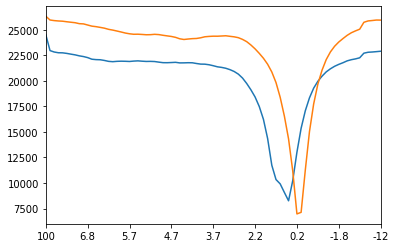

In [13]:
X[data.pH == 6.56].mean(axis = 0).plot()
X[data.pH == 7.03].mean(axis = 0).plot()

In [21]:
X.columnunique

AttributeError: 'DataFrame' object has no attribute 'columnunique'

In [14]:
metadata

['pH',
 'Conc(mM)',
 'ApproT1(sec)',
 'Temp',
 'SatPower(uT)',
 'SatTime(ms)',
 'pH_corr']

Text(0.5, 1.0, 'Average Nornalized Z-spectra')

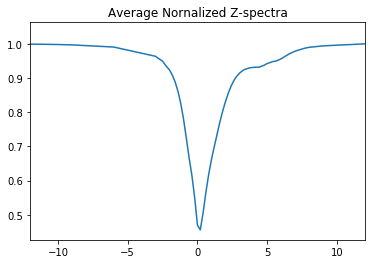

In [15]:
plt.plot(ppm, X.mean().values / X.mean().values [1])
plt.xlim([-12,12])
plt.title('Average Nornalized Z-spectra')

(16128, 76)


Text(0.5, 1.0, 'Average Nornalized Z-spectra')

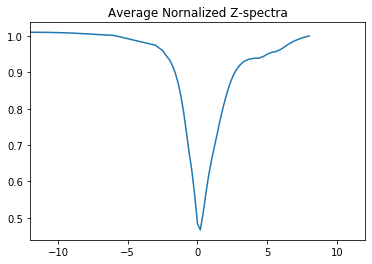

In [16]:
norm_point = 5

#inline fuction
foo = lambda s: (normalize_cest(s,norm_point))

Z = X.apply(foo, axis = 1)
xdata = ppm[norm_point::]
print(Z.shape)

plt.plot(xdata, Z.mean())
plt.xlim([-12,12])
plt.title('Average Nornalized Z-spectra')

pH                 6.57
Conc(mM)          49.85
ApproT1(sec)       0.60
Temp              42.00
SatPower(uT)       3.00
SatTime(ms)     2002.40
Name: 2, dtype: float64


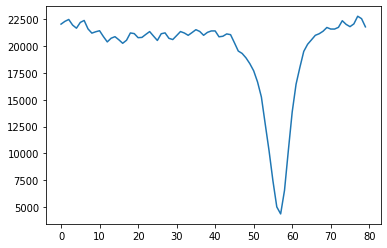

In [53]:
plt.figure()
idx = np.random.randint(0, high=16000, size=(1,1))
print( data.iloc[int(idx),:].head(6) )
plt.plot(data.iloc[int(idx),:].values[7:87]);


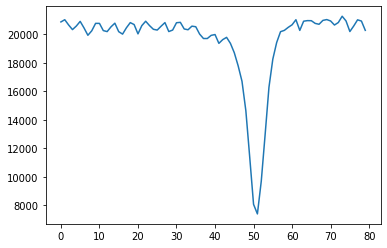

pH                 6.42
Conc(mM)           5.15
ApproT1(sec)       3.40
Temp              42.00
SatPower(uT)       3.00
SatTime(ms)     6002.40
Name: 1, dtype: float64

In [21]:
X.shape

(16128, 81)

In [18]:
data.shape

(16128, 88)

Text(0.5, 1.0, 'Average Nornalized Z-spectra')

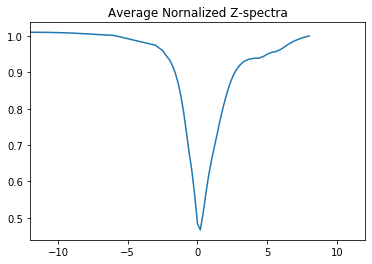

In [17]:
plt.plot(xdata, Z.mean())
plt.xlim([-12,12])
plt.title('Average Nornalized Z-spectra')

### PCA -- > Logistic Regression

In [54]:
### define function to train model based on cuttoff for pH

def train_logistic_PCA_pipeline(Spectra, pH_observed, min_n=2, max_n= 10, pH_cut_off = 7.0, n_cs=20):
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Spectra.copy()
        
    # Logistic
    logistic = linear_model.LogisticRegression(solver='liblinear', penalty='l1',max_iter=500,random_state=42, n_jobs=2)

    #PCA
    pca = PCA(random_state=42)
    
    # pipeline
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    
    # Training parameters
    num_pca_components = np.arange(min_n,max_n,1)
    Cs = np.logspace(-3, 2, n_cs)
    
    param_grid ={
    'pca__n_components': num_pca_components,
    'logistic__C': Cs,
    'logistic__class_weight': ['balanced',None]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 1, cv = 3, n_jobs=6, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #Confusion
    skplt.metrics.plot_confusion_matrix(y_test, estimator.predict(X_test), normalize=True)
    
    
    return estimator.best_estimator_, X_train, X_test, y_train, y_test

###  -training pH >7.0   
### ALL conditions

In [55]:
(pH> 7).value_counts(normalize = True).round(2)

False    0.7
True     0.3
Name: pH_corr, dtype: float64

In [56]:
from sklearn import metrics

In [57]:
import scikitplot as skplt

In [58]:
pH_class = 1*( clf_01.predict(Xdata.values) > 7 )
plt.figure(dpi = 100)

skplt.metrics.plot_confusion_matrix(pH_class, clf_01.predict(Xdata), normalize=True)

NameError: name 'clf_01' is not defined

In [60]:
import seaborn as sns

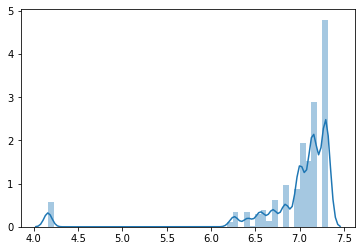

In [61]:
sns.distplot(data[ pH_class != clf_01.predict(Xdata) ].pH.values)

In [65]:
data[ pH_class != clf_01.predict(Xdata) ].groupby(['pH','Conc(mM)']).size()

pH    Conc(mM)
4.16  48.36       131
6.23  5.19          8
      24.94         6
      49.86        12
6.26  51.67        10
                 ... 
7.31  24.84       108
      47.62       125
      47.89        47
7.32  24.91        81
      24.95        53
Length: 93, dtype: int64

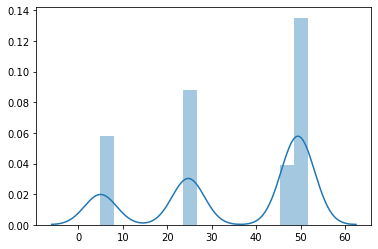

In [63]:
sns.distplot(data[ pH_class != clf_01.predict(Xdata) ]['Conc(mM)'].values)

0     False
1     False
2     False
3     False
4     False
      ...  
23     True
24     True
25     True
26     True
27     True
Name: Conc(mM), Length: 16128, dtype: bool

In [59]:
data[ pH_class != clf_01.predict(Xdata) ].pH.value_counts(normalize = 1)

7.31    0.093977
7.01    0.090630
7.12    0.078918
7.18    0.076966
7.29    0.075293
7.27    0.054657
7.14    0.045176
7.28    0.041550
7.32    0.037368
4.16    0.036531
7.16    0.036252
6.98    0.030954
7.17    0.024261
6.84    0.021472
6.85    0.020357
6.57    0.020078
6.97    0.019520
6.71    0.019520
7.13    0.017568
6.27    0.017011
6.82    0.015337
6.69    0.014780
7.02    0.013385
6.53    0.011712
7.03    0.011154
6.41    0.010876
7.05    0.007529
6.23    0.007250
6.67    0.005020
6.43    0.004183
6.58    0.003904
6.68    0.003904
6.96    0.003625
6.56    0.003625
6.52    0.003346
6.42    0.003346
6.38    0.003067
6.26    0.002789
6.86    0.002789
6.73    0.001952
6.28    0.001673
6.83    0.001394
6.70    0.001115
6.72    0.001115
6.44    0.001115
6.99    0.000837
6.54    0.000558
6.40    0.000558
Name: pH, dtype: float64

In [38]:
clf_01.predict_proba(Xdata[0,:])

TypeError: '(0, slice(None, None, None))' is an invalid key

In [79]:
data['Conc(mM)'].describe()

count    16128.000000
mean        26.616696
std         18.844301
min          4.810000
25%          5.170000
50%         24.860000
75%         48.945000
max         51.690000
Name: Conc(mM), dtype: float64

Fitting 3 folds for each of 1520 candidates, totalling 4560 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    8.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   16.9s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   27.7s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   41.8s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:   58.6s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 4560 out of 4560 | elapsed:  2.4min finished
C:\Users\jdata\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=37,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 LogisticRegression(C=0.003359818286283781, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=500, multi_class='warn', n_jobs=2,
                                    penalty='l1', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


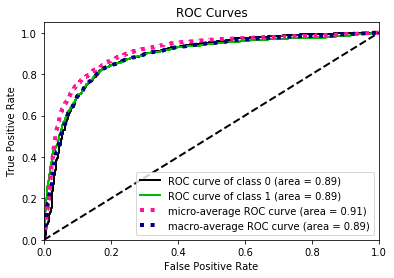

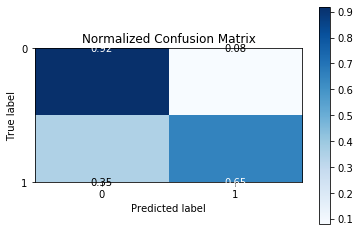

In [59]:
Xdata = X.drop('100',axis  = 1).copy()

conc_filter = data['Conc(mM)'] > 20

clf_01,  _, _, _, _  = train_logistic_PCA_pipeline( Xdata[conc_filter], pH[conc_filter], min_n=2, max_n= 40, pH_cut_off = 7.0, n_cs= 20)

print(clf_01)

###  -training pH >7.0
## at 37 celsius

pH
[ 6.23  6.42  6.56  6.72  6.86  7.05  7.14  7.31  6.27  6.4   6.52  6.69
  6.85  6.96  7.12  7.28  6.28  6.38  6.54  6.68  7.02  7.13  7.29  6.73
  6.83  6.98  7.18  6.26  6.44  6.53  6.82  7.01  6.58  6.84  4.16  7.16
  7.27  6.41  6.57  6.71  6.97  6.39  6.43  6.67  6.7   6.99  7.03  7.32
  6.22  7.17]
------------------------------------------------------------
Conc(mM)
[  5.19   5.15   5.18   5.13   5.1    5.03   5.17   5.11   4.98   5.06
   5.05   5.     4.81   5.16   5.02   4.99  51.67  51.55  51.38  51.69
  51.33  51.01  50.39  50.    49.7   49.65  49.8   49.51  49.46  48.92
  48.36  47.62  49.78  49.67  49.36  49.02  49.77  49.86  49.6   49.85
  49.63  49.31  49.88  48.83  48.68  48.77  48.53  48.35  47.88  47.89
  24.94  24.81  24.9   24.84   4.97   4.95   4.89  24.73  24.61  24.87
  24.97  24.95  24.91  24.93  24.85  24.75  24.53  24.98  24.88  24.83
  24.7   24.57  24.82]
------------------------------------------------------------
ApproT1(sec)
[ 3.4   1.4   0.86  0.6   0

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 716 tasks      | elapsed:    6.3s
[Parallel(n_jobs=6)]: Done 1716 tasks      | elapsed:   14.9s
[Parallel(n_jobs=6)]: Done 3116 tasks      | elapsed:   27.9s
[Parallel(n_jobs=6)]: Done 4560 out of 4560 | elapsed:   42.5s finished
/Users/Julio/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=37, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


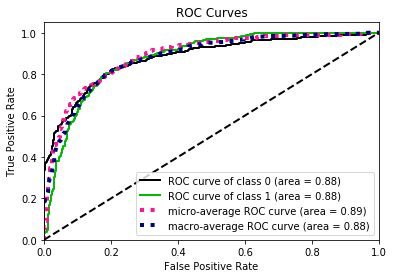

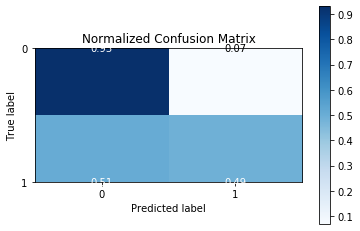

In [26]:
f1 = data['Temp'] == 37

for C in metadata:
    print(C)
    print(data[f1][C].unique())
    print('---'*20)
    
    
X = data[f1].drop(metadata,axis = 1)
Z = X.apply(foo, axis = 1)
print(X.shape)
print(Z.shape)

pH = data[f1]['pH'].copy()


clf_02,  _, _, _, _  = train_logistic_PCA_pipeline( Z, pH, min_n=2, max_n= 40, pH_cut_off = 7.0, n_cs= 20)
print(clf_02)

In [29]:
print( metrics.classification_report(pH > 7, clf_02.predict(Z)) )

              precision    recall  f1-score   support

       False       0.83      0.94      0.88      2844
        True       0.79      0.55      0.65      1188

   micro avg       0.82      0.82      0.82      4032
   macro avg       0.81      0.75      0.77      4032
weighted avg       0.82      0.82      0.81      4032



##  training pH >7.0
### - at 37 celsius & T1  = 3.4

pH
[ 6.23  6.42  6.56  6.72  6.86  7.05  7.14  7.31  6.26  6.44  6.53  6.69
  6.82  7.01  7.12  7.29  6.43  6.67  7.28]
------------------------------------------------------------
Conc(mM)
[  5.19   5.15   5.18   5.13   5.1    5.03  51.67  51.55  51.38  51.69
  51.33  51.01  50.39  50.    24.94  24.81  24.9   24.84  24.73  24.61
  24.87]
------------------------------------------------------------
ApproT1(sec)
[ 3.4]
------------------------------------------------------------
Temp
[37]
------------------------------------------------------------
SatPower(uT)
[ 0.5  1.   2.   3.   4.   6. ]
------------------------------------------------------------
SatTime(ms)
[ 1002.4   2002.4   3002.4   4002.4    502.42  6002.4 ]
------------------------------------------------------------
pH_corr
[ 6.23  6.42  6.56  6.72  6.86  7.05  7.14  7.31  6.26  6.44  6.53  6.69
  6.82  7.01  7.12  7.29  6.43  6.67  7.28]
------------------------------------------------------------
(864, 81)
(864, 80)
Fitti

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 532 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 3532 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Done 4560 out of 4560 | elapsed:   16.7s finished
/Users/Julio/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=25, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=29.763514416313193, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='warn', n_jobs=2, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


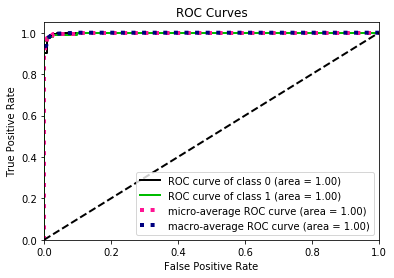

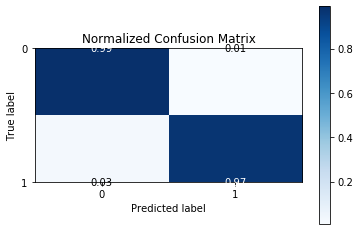

In [43]:
f1 = data['Temp'] == 37
f2 = data['ApproT1(sec)'] == 3.4


for C in metadata:
    print(C)
    print(data[f1&f2][C].unique())
    print('---'*20)
    
    
X = data[f1&f2].drop(metadata,axis = 1)
Z = X.apply(foo, axis = 1)
print(X.shape)
print(Z.shape)

pH = data[f1&f2]['pH'].copy()


clf_04,  _, _, _, _  = train_logistic_PCA_pipeline( Z, pH, min_n=2, max_n= 40, pH_cut_off = 7.0, n_cs= 20)
print(clf_04)

In [44]:
print( metrics.classification_report(pH > 7, clf_04.predict(Z)) )

print( metrics.confusion_matrix(pH > 7, clf_04.predict(Z)) )

print( metrics.cohen_kappa_score(pH > 7, clf_04.predict(Z)) )

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       540
        True       0.98      0.98      0.98       324

   micro avg       0.99      0.99      0.99       864
   macro avg       0.99      0.99      0.99       864
weighted avg       0.99      0.99      0.99       864

[[534   6]
 [  5 319]]
0.972856261567


Text(0.5, 1.0, 'Average Nornalized Z-spectra')

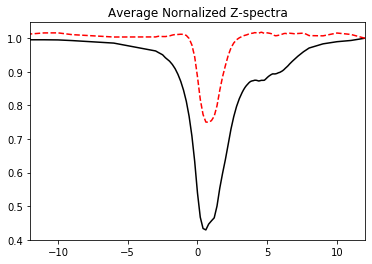

In [35]:
plt.plot(xdata, Z.mean(),'-k')
plt.plot(xdata, Z.mean() + Z.std(),'--r')

plt.xlim([-12,12])
plt.title('Average Nornalized Z-spectra')

##  training pH >7.0
### - at 42 celsius & T1  = 0.43

pH
[ 6.27  6.39  6.52  6.69  6.84  6.97  7.14  7.31  6.23  6.42  6.53  6.7
  6.86  7.18  7.27]
------------------------------------------------------------
Conc(mM)
[ 48.83  48.68  48.77  48.53  48.35  47.88  47.89   4.99   4.98   4.97
   4.95   4.89]
------------------------------------------------------------
ApproT1(sec)
[ 0.43]
------------------------------------------------------------
Temp
[42]
------------------------------------------------------------
SatPower(uT)
[ 0.5  1.   2.   3.   4.   6. ]
------------------------------------------------------------
SatTime(ms)
[ 1002.4   2002.4   3002.4   4002.4    502.42  6002.4 ]
------------------------------------------------------------
pH_corr
[ 6.27  6.39  6.52  6.69  6.84  6.97  7.14  7.31  6.23  6.42  6.53  6.7
  6.86  7.18  7.27]
------------------------------------------------------------
(576, 81)
(576, 80)
Fitting 3 folds for each of 1520 candidates, totalling 4560 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 428 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 2828 tasks      | elapsed:    8.6s
[Parallel(n_jobs=6)]: Done 4560 out of 4560 | elapsed:   15.2s finished
/Users/Julio/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=39, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


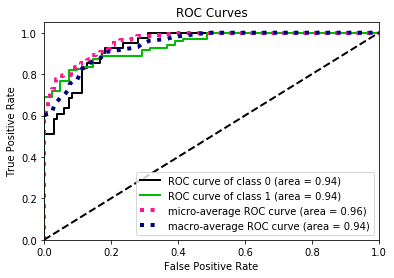

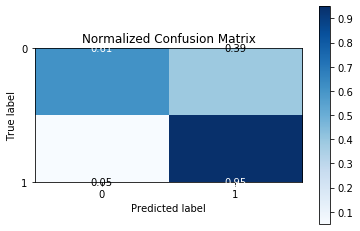

In [38]:
f1 = data['Temp'] == 42
f2 = data['ApproT1(sec)'] == .43


for C in metadata:
    print(C)
    print(data[f1&f2][C].unique())
    print('---'*20)
    
    
X = data[f1&f2].drop(metadata,axis = 1)
Z = X.apply(foo, axis = 1)
print(X.shape)
print(Z.shape)

pH = data[f1&f2]['pH'].copy()


clf_05,  _, _, _, _  = train_logistic_PCA_pipeline( Z, pH, min_n=2, max_n= 40, pH_cut_off = 6.5, n_cs= 20)
print(clf_05)

In [39]:
print( metrics.classification_report(pH > 7, clf_05.predict(Z)) )

print( metrics.confusion_matrix(pH > 7, clf_05.predict(Z)) )

print( metrics.cohen_kappa_score(pH > 7, clf_05.predict(Z)) )

              precision    recall  f1-score   support

       False       0.99      0.28      0.43       432
        True       0.31      0.99      0.48       144

   micro avg       0.46      0.46      0.46       576
   macro avg       0.65      0.64      0.46       576
weighted avg       0.82      0.46      0.44       576

[[120 312]
 [  1 143]]
0.157469717362


In [42]:
pd.Series(pH > 7).value_counts(normalize  = 1)

False    0.75
True     0.25
Name: pH, dtype: float64

In [ ]:
z1 = data[ data.pH == 6.23 ].iloc[:,6::].mean()
z1 = z1 / z1[1]


z2 = data[ data.pH == 7.17 ].iloc[:,6::].mean()
z2 = z2 / z2[1]

z1.plot()
z2.plot()

In [ ]:
data.pH.unique()

In [ ]:
plt.plot(xdata, Z.mean(),'-k')
plt.plot(xdata, Z.mean() + Z.std(),'--r')

plt.xlim([-12,12])
plt.title('Average Nornalized Z-spectra')